# This is the most up to date motor control example. Refer here to work with the FPGA through the network connection

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("..")
sys.path.append("../../")

from armControl import *
from forwardKinematics import robot_config
from utils.motor_setup import maxonLarge
import signal

import matplotlib.pyplot as plt


In [161]:
socket_ip = '192.168.0.115'
socket_port = 1122

#trajPlanner = trajectoryGenerator()

motors = maxonLarge()
motors.tcp_init(socket_ip, socket_port)

Opening socket at ip: 192.168.0.115 using port: 1122


In [162]:
print("Arming motors now...")
motors.arm_motors()


Arming motors now...
initializing motors to [ 40 -74   0   0   0   0   0   0]
Arming motors


# benchmark communication speed

average time: 0.002061952232229601
std time: 0.0002739909004890167


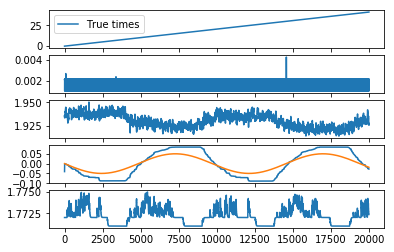

In [169]:
setpoint = np.zeros(8)
import time

#time_list = []
true_times = []
adc = []
encoders = []
setpoints = []
start = time.time()
for i in range(20000):
    #time_list.append(time.time()-start)
    setpoint = np.ones(8)*np.sin((time.time()-start)*np.pi*2/20)/20
    setpoints.append(setpoint)
    motors.command_motors_radians(setpoint)
    true_times.append(motors.command_time)
    adc.append(motors.avg_current)
    encoders.append(motors.get_motors_position_radians())

motors.run_trajectory(setpoints = np.zeros(8), velocity=np.ones(8)/20)

setpoints = np.array(setpoints)
true_times = np.array(true_times)[1:]/10**9
encoders = np.array(encoders)
adc = np.array(adc)

true_times = true_times - true_times[0]

diffs = true_times[1:] - true_times[:-1]
print('average time: {}'.format(diffs.mean()))
print('std time: {}'.format(diffs.std()))

plt.figure()
#plt.plot(time_list)
plt.subplot(5,1,1)
plt.plot(true_times)
plt.legend(['True times'])
plt.subplot(5,1,2)
plt.plot(diffs)
plt.subplot(5,1,3)
plt.plot(adc[:,6])
plt.subplot(5,1,4)
plt.plot(encoders[:,1])
plt.plot(-setpoints[:,0])
plt.subplot(5,1,5)
plt.plot(adc[:,1])
plt.show()

# current plotting

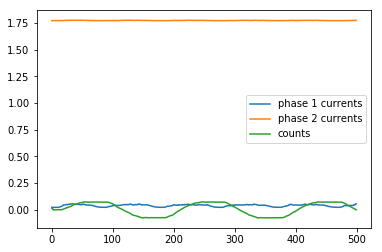

In [170]:

velocity = np.ones(8)*(np.pi/10)


setpoint = np.zeros(8)
currents_left = []
currents_right = []
counts_left = []
motor_position = []

start = time.time()
for i in range(500):
    setpoint = np.ones(8)*np.sin((time.time()-start)*2*np.pi/2)/10
    currents_left.append(motors.avg_current[0])
    currents_right.append(motors.avg_current[1])
    #counts_left.append(motors.get_motors_position_radians())
    motor_position.append(motors.get_motors_position_radians())
    
    motors.command_motors_radians(setpoint)
    time.sleep(0.01)

motors.command_motors_radians(np.zeros(8))

currents_left = np.array(currents_left)
counts_left = np.array(counts_left)
motor_position = np.array(motor_position)

plt.plot(currents_left)
plt.plot(currents_right)
plt.plot(motor_position[:,0])
plt.legend(['phase 1 currents', 'phase 2 currents', 'counts'])

In [179]:
motor_position.shape

(100, 8)

In [199]:
motors.command_motors_radians(np.zeros(8))
print(motors.get_motors_position_radians())


[ 0.00000000e+00 -1.57079633e-04  0.00000000e+00  1.13050212e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


# zeroing code

0.0


IndexError: too many indices for array

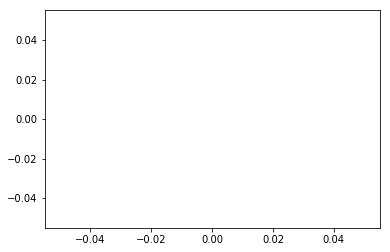

In [10]:
for i in range(1):
    setpoint = np.zeros(8)
    currents_left = []
    counts_left = []

    while motors.avg_current[0] < 0.15:
        setpoint = setpoint + 0.01
        currents_left.append(motors.avg_current[0])
        counts_left.append(motors.get_motors_position_radians())
        motors.command_motors_radians(setpoint)
        time.sleep(0.01)
    zero_left = motors.get_motors_position_radians()

    motors.run_trajectory(np.zeros(8), velocity)

    setpoint = np.zeros(8)    
    currents_right = []
    counts_right = []
    while motors.avg_current[0] < 0.15:
        setpoint = setpoint - 0.01
        currents_right.append(motors.avg_current[0])
        counts_right.append(motors.get_motors_position_radians())
        motors.command_motors_radians(setpoint)
        time.sleep(0.01)
    zero_right = motors.get_motors_position_radians()

    motor_zero_new = (zero_right[1] + zero_left[1])/2
    motors.zero_motors_radians(1, motor_zero_new)

    motors.run_trajectory(np.zeros(8), velocity)
    print(motor_zero_new)

currents_left = np.array(currents_left)
counts_left = np.array(counts_left)
currents_right = np.array(currents_right)
counts_right = np.array(counts_right)

plt.plot(currents_left)
plt.plot(np.abs(counts_left[:,1])/5)
plt.plot(currents_right)
plt.plot(np.abs(counts_right[:,1])/5)
plt.legend(['left currents', 'left counts', 'right currents', 'right counts'])

## Tuning gains based on oscillation

currents = []
positions = []

start = time.time()
while time.time() - start < 10:
    currents.append(motors.avg_current[0])
    positions.append(motors.get_motors_position_radians())
    time.sleep(0.01)

currents = np.array(currents)
positions = np.array(positions)

plt.plot(currents)
plt.plot(positions[:,1]/5)
plt.legend(['currents', 'position'])

Mean error: 11.677003236156613


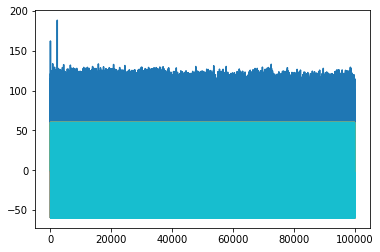

In [608]:
dt = 0.01
runtime = 1000
num_elements = int(runtime/dt)
setpoints = np.zeros((num_elements, 8))
frequency = 1
for i in range(num_elements):
    setpoints[i,:] = (np.ones(8) * np.sin(i*dt*2*pi*frequency)*3.14/3)


start_time = time.time()

currents_mA = []
counts = []
for i in range(num_elements):
    current_time = time.time()
    #print(enc_position)
    setpoint = setpoints[i]
    motors.command_motors_radians(setpoint)
    currents_mA.append(1000*motors.avg_current)
    counts.append(motors.get_motors_position_radians())
    time.sleep(dt)
    
motors.run_trajectory(np.zeros(8), velocity)

currents_mA = np.array(currents_mA)
counts = np.array(counts)
plt.plot(currents_mA[:,0])
plt.plot(counts[:,1]*180/np.pi)
plt.plot(setpoints*180/np.pi)

print('Mean error: {}'.format(np.mean(np.abs(counts[:,1]-setpoints[:,1]))*180/np.pi))

In [159]:
motors.tcp_close()